# classification-02

## What's new:

1-

## next step:

1- Improve labeling ( 3333 from 28-1111 )


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Reshape, TimeDistributed, Lambda
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import talib


2025-10-22 16:14:13.289023: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-22 16:14:13.448491: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# 1- Load and Scaling Features

df = pd.read_csv('XAGUSD-197001010000--H1-rates.csv', sep='\t')
# Rename columns for easier access
df.rename(columns={
    '<DATE>': 'DATE',
    '<TIME>': 'TIME',
    '<OPEN>': 'OPEN',
    '<HIGH>': 'HIGH',
    '<LOW>': 'LOW',
    '<CLOSE>': 'CLOSE',
    '<TICKVOL>': 'TICKVOL',
    '<VOL>': 'VOL',
    '<SPREAD>': 'SPREAD'
}, inplace=True)

# ensure strings and strip any weird whitespace
df['DATE'] = df['DATE'].astype(str).str.strip()
df['TIME'] = df['TIME'].astype(str).str.strip()

df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], dayfirst=False, errors='coerce')
if df['DATETIME'].isna().any():
    raise ValueError("Some DATETIME values could not be parsed. Check date/time formats.")

# set DATETIME as index for reindexing
df = df.set_index('DATETIME').sort_index()

# --------------------------
# Create continuous hourly index & fill weekend gaps
# --------------------------
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')

# Reindex to full hourly range so weekends/missing hours appear as NaN rows
df = df.reindex(full_index)

# Fill strategy:
# - Prices: forward-fill last known price across weekend gap (common approach for modeling continuity).
# - TICKVOL / VOL: set missing to 0 (no ticks during weekend).
# - SPREAD: forward-fill last known.
# Alternative: you could leave NaNs and drop sequences that cross weekends (safer but reduces data).
df[['OPEN', 'HIGH', 'LOW', 'CLOSE']] = df[['OPEN', 'HIGH', 'LOW', 'CLOSE']].ffill()
df['SPREAD'] = df['SPREAD'].ffill()
df['TICKVOL'] = df['TICKVOL'].fillna(0)
df['VOL'] = df['VOL'].fillna(0)

# Reset index to make DATETIME a regular column again
df = df.reset_index().rename(columns={'index': 'DATETIME'})

In [3]:
df.shape

(179856, 10)

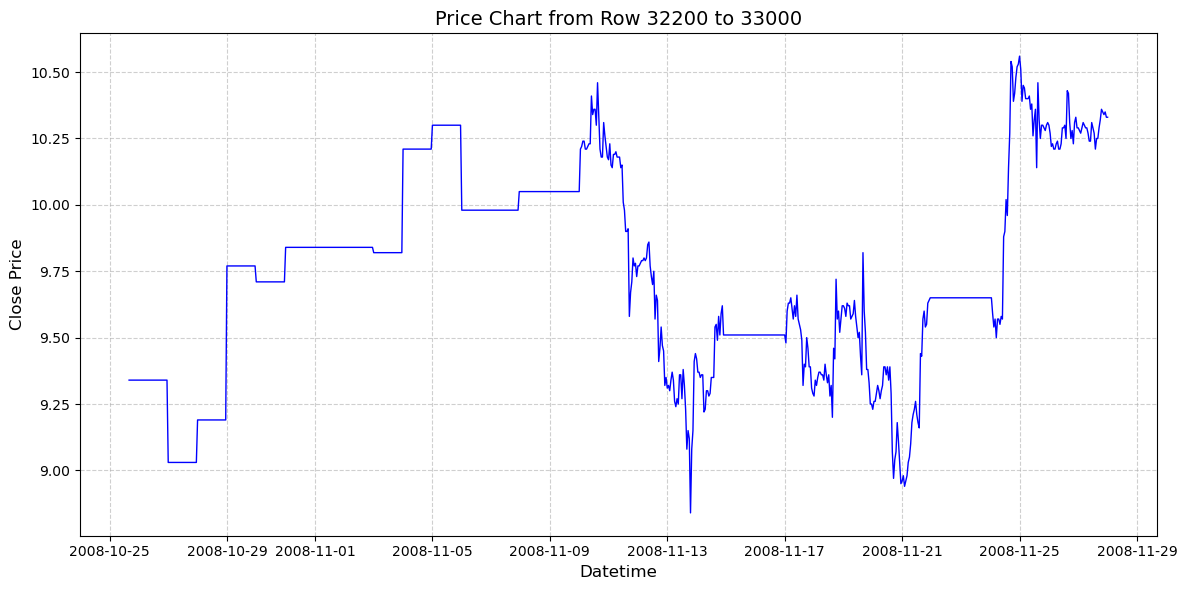

In [4]:
import matplotlib.pyplot as plt

# Example: choose the start and end rows
start_row = 32200
end_row = 33000

# Select the range and make a copy to avoid SettingWithCopyWarning
subset = df.iloc[start_row:end_row + 1].copy()

# Ensure DATETIME is datetime type
subset['DATETIME'] = pd.to_datetime(subset['DATETIME'])

# Plot CLOSE price over time
plt.figure(figsize=(12, 6))
plt.plot(subset['DATETIME'], subset['CLOSE'], linewidth=1.0, color='blue')

# Labels and formatting
plt.title(f"Price Chart from Row {start_row} to {end_row}", fontsize=14)
plt.xlabel("Datetime", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [5]:
# Specify how many rows to remove for model
nn = 33000   # Delete the first nn rows that do not follow the one-hour timeframe.
mm = 500   # Remove mm last row that the model should not see.

# Delete first nn and last mm rows
df_model = df.iloc[nn:len(df)-mm].reset_index(drop=True)

In [6]:
# 2- Label trend reversals (example: a simplistic method)
def label_reversal_points(prices, window=8, threshold=0.002):
    prices = np.asarray(prices)
    labels = [0] * len(prices)
    prev_trend = 0  # 1 = up, -1 = down, 0 = unknown

    for i in range(len(prices) - window):
        past = prices[i:i + window // 2]
        future = prices[i + window // 2:i + window]

        past_mean = np.mean(past)
        future_mean = np.mean(future)
        change = (future_mean - past_mean) / past_mean

        if change > threshold:
            curr_trend = 1  # Uptrend
        elif change < -threshold:
            curr_trend = -1  # Downtrend
        else:
            curr_trend = 0  # No significant trend

        # Detect a reversal (trend direction changed)
        if prev_trend == -1 and curr_trend == 1:
            labels[i + window // 2] = 1  # Buy signal at start of uptrend
        elif prev_trend == 1 and curr_trend == -1:
            labels[i + window // 2] = 2  # Sell signal at start of downtrend

        # Update previous trend only if there is a new clear trend
        if curr_trend != 0:
            prev_trend = curr_trend

    return labels

df_model['Label'] = label_reversal_points(df_model['CLOSE'].values)

In [7]:
print(df_model['Label'].value_counts().sort_index())  # 0, 1, 2

Label
0    137903
1      4227
2      4226
Name: count, dtype: int64


In [8]:
import matplotlib.pyplot as plt

def plot_labeled_candles(df, n=190):
    """
    Plots the last n candles with BUY/SELL labels based on the 'Label' column.
    Assumes df already has a 'DATETIME' column.
    """
    # Drop NaN rows (e.g., weekend gaps)
    df_plot = df.dropna(subset=['CLOSE']).tail(n).copy()

    # Ensure DATETIME is a datetime column (optional safeguard)
    if not pd.api.types.is_datetime64_any_dtype(df_plot['DATETIME']):
        df_plot['DATETIME'] = pd.to_datetime(df_plot['DATETIME'])

    # === Plot Close Price ===
    plt.figure(figsize=(15, 6))
    plt.plot(df_plot['DATETIME'], df_plot['CLOSE'], label='Close Price', color='black', linewidth=1.5)

    # === Plot BUY (1) and SELL (2) signals ===
    for _, row in df_plot.iterrows():
        if row['Label'] == 1:  # BUY
            plt.axvline(x=row['DATETIME'], color='green', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'BUY', color='green', ha='center', va='bottom', fontsize=9)
        elif row['Label'] == 2:  # SELL
            plt.axvline(x=row['DATETIME'], color='red', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'SELL', color='red', ha='center', va='top', fontsize=9)

    # === Aesthetics ===
    plt.title(f'Last {n} Candles with Trend Reversal Labels')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.legend()
    plt.show()



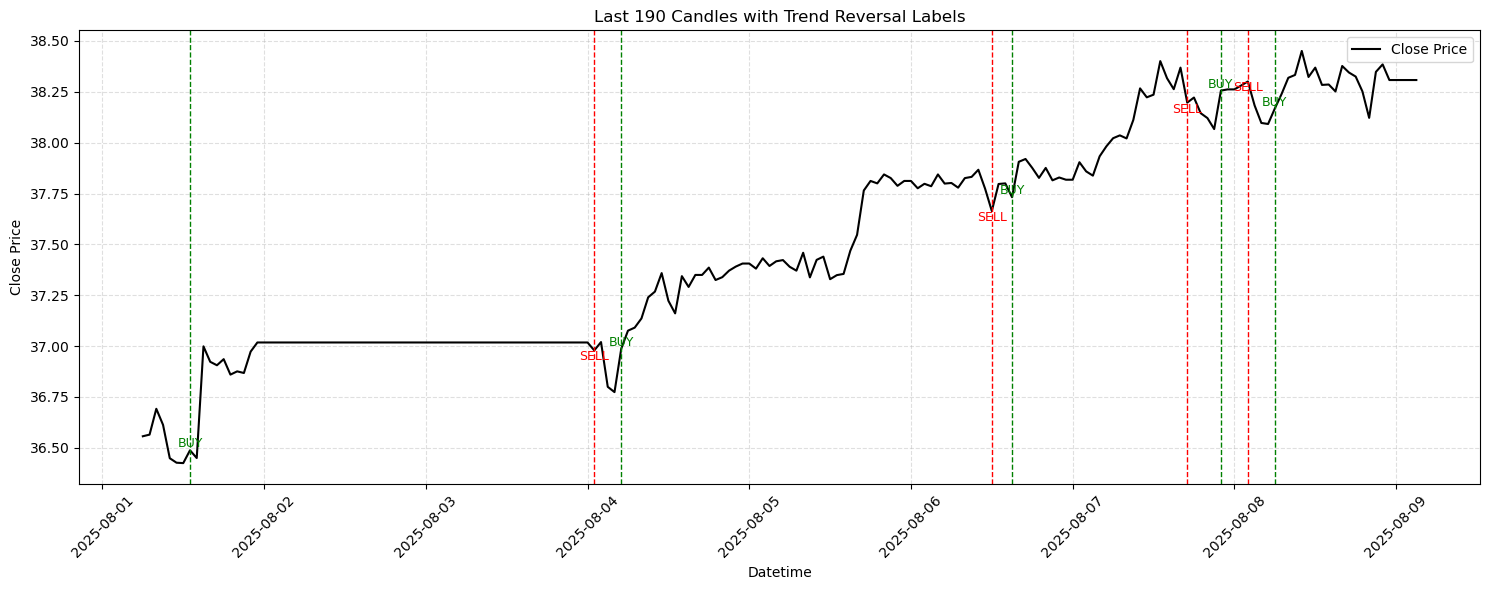

In [9]:
plot_labeled_candles(df_model)

In [10]:
# Select features to scale
features = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']

# Apply MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_model[features])

In [11]:
# 3- Prepare Sequences

given_time = "2024.05.03 01:00:00"   # starting datetime
WINDOW_SIZE = 60
FORECAST_HORIZON = 10
X, y = [], []

for i in range(WINDOW_SIZE, len(scaled) - FORECAST_HORIZON):
    X_seq = scaled[i - WINDOW_SIZE:i]  # (60, 5)
    y_seq = df_model['Label'].iloc[i:i + FORECAST_HORIZON].values  # 10 labels (0/1/2)
    X.append(X_seq)
    y.append(y_seq)

X = np.array(X)  # shape: (samples, 60, 5)
y = np.array(y)  # shape: (samples, 10)

In [12]:
# 4- Split dataset
# Reserve last sample as test input
X_train, y_train = X[:-1], y[:-1]
X_test, y_test = X[-1:], y[-1:]

In [13]:
# 5- One-hot encode each timestep's class (3 classes → depth = 3)
# Convert labels to one-hot for each timestep
y_train_onehot = np.array([to_categorical(seq, num_classes=3) for seq in y_train])
y_test_onehot = np.array([to_categorical(seq, num_classes=3) for seq in y_test])


In [14]:
# 6- Build LSTM Classification Model
model = Sequential([
    Input(shape=(WINDOW_SIZE, X.shape[2])),  # (60, 5)
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(64, activation='relu')),
    TimeDistributed(Dense(3, activation='softmax')),
    Lambda(lambda x: x[:, -FORECAST_HORIZON:, :])  # Keep only last 10 timesteps
])


In [15]:
# 7- Compile model

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy')
    ]
)

In [16]:
# 8- Fit model

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train,
    y_train_onehot,
    epochs=50,  # adjust based on convergence
    batch_size=64,
    validation_split=0.1,
    shuffle=False,  # Important: keep time order!
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
2058/2058 ━━━━━━━━━━━━━━━━━━━━ 91s 42ms/step - accuracy: 0.9420 - loss: 0.2660 - top_2_accuracy: 0.9711 - val_accuracy: 0.9412 - val_loss: 0.2644 - val_top_2_accuracy: 0.9706
Epoch 2/50
2058/2058 ━━━━━━━━━━━━━━━━━━━━ 86s 42ms/step - accuracy: 0.9423 - loss: 0.2604 - top_2_accuracy: 0.9711 - val_accuracy: 0.9412 - val_loss: 0.2675 - val_top_2_accuracy: 0.9699
Epoch 3/50
2058/2058 ━━━━━━━━━━━━━━━━━━━━ 85s 41ms/step - accuracy: 0.9423 - loss: 0.2566 - top_2_accuracy: 0.9709 - val_accuracy: 0.9412 - val_loss: 0.2579 - val_top_2_accuracy: 0.9695
Epoch 4/50
2058/2058 ━━━━━━━━━━━━━━━━━━━━ 85s 41ms/step - accuracy: 0.9423 - loss: 0.2544 - top_2_accuracy: 0.9711 - val_accuracy: 0.9412 - val_loss: 0.2726 - val_top_2_accuracy: 0.9695
Epoch 5/50
2058/2058 ━━━━━━━━━━━━━━━━━━━━ 88s 43ms/step - accuracy: 0.9423 - loss: 0.2531 - top_2_accuracy: 0.9712 - val_accuracy: 0.9412 - val_loss: 0.2531 - val_top_2_accuracy: 0.9701
Epoch 6/50
2058/2058 ━━━━━━━━━━━━━━━━━━━━ 91s 44ms/step - accuracy: 0.

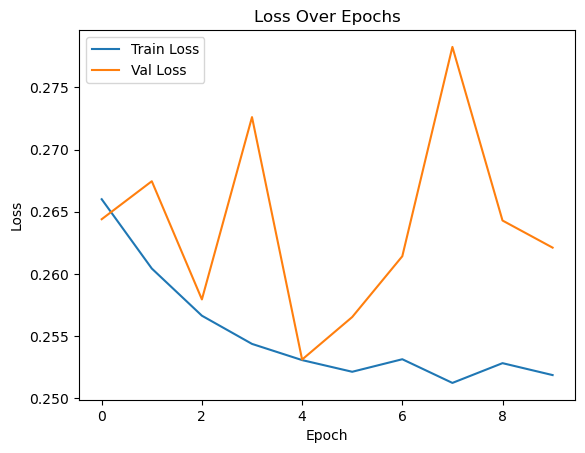

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [18]:
# === Load and clean the last 60 rows from a separate CSV file for prediction ===
# --- Find the starting index ---
start_idx = df.index[df['DATETIME'] == pd.to_datetime(given_time)][0]

# --- 1. Extract next n candles ---
input_df = df.iloc[start_idx : start_idx + WINDOW_SIZE].copy()


# Scale
input_features = input_df[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']]
input_scaled = scaler.transform(input_features)
input_sequence = np.expand_dims(input_scaled, axis=0)  # (1, 60, 5)

# Predict
pred_probs = model.predict(input_sequence)  # shape: (1, 10, 3)
pred_classes = np.argmax(pred_probs[0], axis=1)
print("Predicted Classes:", pred_classes)  # 0=no signal, 1=buy, 2=sell

# Timestamps for forecast
last_timestamp = input_df['DATETIME'].iloc[-1]
datetime_index = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1),
                                   periods=FORECAST_HORIZON, freq='h')

# Output DataFrame
predicted_df = pd.DataFrame({
    'DATETIME': datetime_index,
    'forecast_class': pred_classes
})
predicted_df['label'] = predicted_df['forecast_class'].map({1: 'buy', 2: 'sell'}).fillna('')

print(predicted_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
Predicted Classes: [0 0 0 0 0 0 0 0 0 0]
             DATETIME  forecast_class label
0 2024-05-05 13:00:00               0      
1 2024-05-05 14:00:00               0      
2 2024-05-05 15:00:00               0      
3 2024-05-05 16:00:00               0      
4 2024-05-05 17:00:00               0      
5 2024-05-05 18:00:00               0      
6 2024-05-05 19:00:00               0      
7 2024-05-05 20:00:00               0      
8 2024-05-05 21:00:00               0      
9 2024-05-05 22:00:00               0      


# plot section

In [19]:
# --- 2. Extract last 4 candles from input_df ---
historical_df = input_df.tail(4).copy()

# --- 3. Extract next 10 candles immediately after input_df ---
actual_future_df = df.iloc[start_idx + WINDOW_SIZE - 1 : start_idx + WINDOW_SIZE + FORECAST_HORIZON].copy()

plot_title = 'Actual vs Predicted Forex Closing Prices'
output_plot_path = None  # e.g., 'output.png'


# 10-3 Generate forecast timestamps ===
# Start 1 hour after the last actual candle
last_timestamp = input_df['DATETIME'].iloc[-1]
datetime_index = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=FORECAST_HORIZON, freq='h')

# 10-4 Create predicted_df with forecasted trend reversals
predicted_df = pd.DataFrame({
    'DATETIME': datetime_index,
    'forecast_class': pred_classes
})


# 10-5 Optional: Add labels for plotting
def class_to_label(c):
    if c == 1:
        return 'buy'
    elif c == 2:
        return 'sell'
    else:
        return None


predicted_df['label'] = predicted_df['forecast_class'].apply(class_to_label)


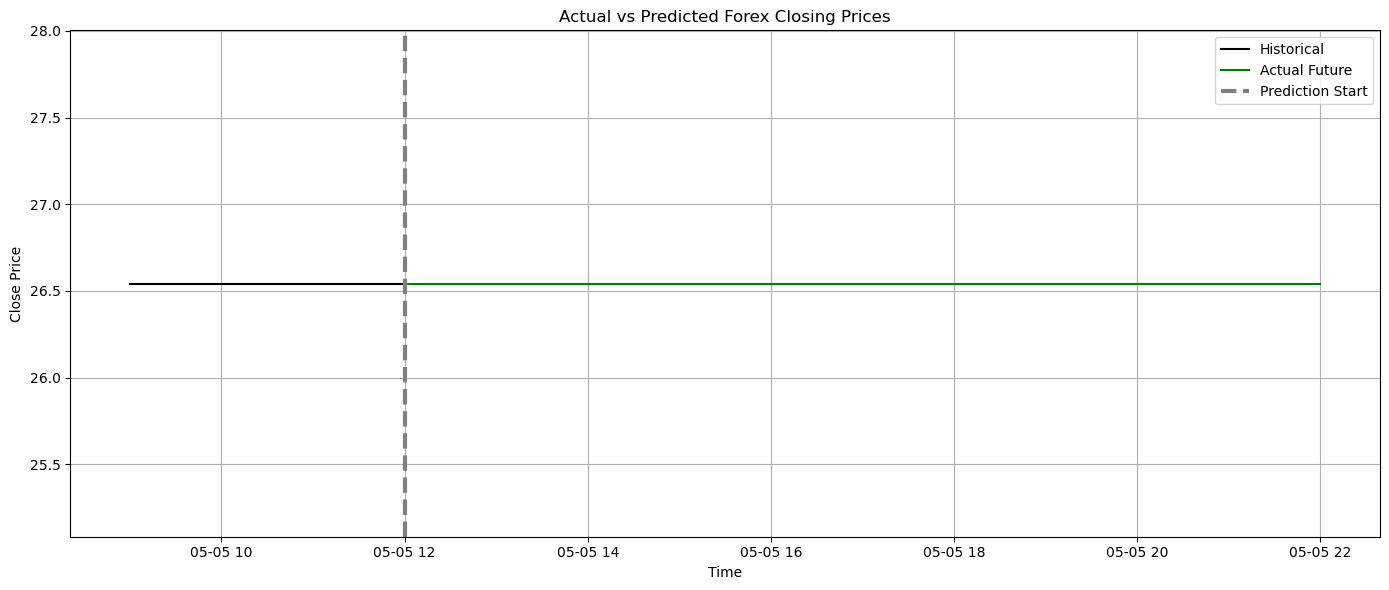

In [20]:
# 10-6 PLOT

import sys
sys.path.insert(1, '../utils')
import forex_plot_utils_2

# PLOT
forex_plot_utils_2.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)



In [21]:
# 11- Save Model

from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt

# 11-1 Create timestamp and paths
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'model_{timestamp}.keras'
model_path = os.path.join('saved_models', model_filename)

# 11-2 Directory to hold logs and extras
log_dir = os.path.join('saved_models', f'model_{timestamp}_logs')
os.makedirs(log_dir, exist_ok=True)

# 11-3 Save model
model.save(model_path)

# 11-4 Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(log_dir, 'training_history.csv'), index=False)

# 11-5 Save training loss plot
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(log_dir, 'training_loss.png'))
plt.close()

# 11-6 Save model summary and final performance
y_test_onehot = to_categorical(y_test, num_classes=3)

with open(os.path.join(log_dir, 'model_log.txt'), 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    final_train_loss = history.history['loss'][-1]
    final_test_loss, final_test_accuracy, final_test_mae = model.evaluate(X_test, y_test_onehot, verbose=0)

    f.write(f'\nFinal Training Loss: {final_train_loss:.6f}\n')
    f.write(f'Final Test Loss: {final_test_loss:.6f}\n')
    f.write(f'Final Test Accuracy: {final_test_accuracy:.6f}\n')

In [ ]:
# Load the trained model
from tensorflow import keras
model = keras.models.load_model('saved_models/model_20251022_163615.keras')